In [2]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
import os
import itertools
import numpy as np
import torch as tr
import pandas as pd
from matplotlib import pyplot as plt

In [31]:
NUM_STATES = 5
class Task_AXCPT():
    def __init__(self):
        nstim,sdim = NUM_STATES,NUM_STATES
        self.embed_mat = np.eye(nstim)
        # sequence of states, rewarded action
        self.trialL = np.array([
            [[1,0,0,3],[0,0,0,1]],
            [[1,0,0,4],[0,0,0,2]],
            [[2,0,0,3],[0,0,0,2]],
            [[2,0,0,4],[0,0,0,1]]
        ])
        return None
      
    def sample_trial(self):
        ttype = np.random.choice(range(4))
        tr_stim,At_plus = self.trialL[ttype] 
        tr_stim = self.embed_mat[tr_stim]
        tr_stim = tr.Tensor(tr_stim).unsqueeze(1)
        return tr_stim,At_plus
      

(4, 2, 4)

In [5]:
class Agent(tr.nn.Module):

    def __init__(self):
        super().__init__()
        self.sdim = NUM_STATES
        self.stsize = 6
        self.nactions = 3
        self._build()
        return None

    def _build(self):
        self.in_layer = tr.nn.Linear(self.sdim,self.sdim)
        self.lstm = tr.nn.LSTM(self.sdim,self.stsize)
        self.init_lstm = tr.nn.Parameter(tr.rand(2,1,1,self.stsize),requires_grad=True)
        self.value_out = tr.nn.Linear(self.stsize,1)
        self.policy_out = tr.nn.Linear(self.stsize,self.nactions)
        return None
    
    def forward(self,t_stim):
        h = t_stim
        h = self.in_layer(h)
        h_lstm,c_lstm = self.init_lstm 
        h, (h_final,c_final) = self.lstm(h,(h_lstm,c_lstm))
        vhat = self.value_out(h)
        phat = self.policy_out(h)
        return vhat,phat
      
    def update(self,rewards_tr,vhat_tr,prob_At):
        returns_tr = rewards_tr
        advantages_tr = vhat_tr - returns_tr 
        loss_v = self.mse_loss_op(vhat_tr,returns_tr)
        loss = loss_v + (np.log(prob_At) * advantages_tr)
        return loss

In [6]:
ag = Agent()
task = Task_AXCPT()
mse_loss_op = tr.nn.MSELoss()
optiop = tr.optim.Adam(ag.parameters(), lr=0.005)
L = []
for trial in range(1):

  # trial 
  tr_stim,At_plus = task.sample_trial()

  # forward prop
  vhat_tr,phat_tr = ag(tr_stim)

  # pi_trial is softmax vector for final action
  pi_tr = phat_tr.softmax(2).squeeze()

  # sample action
  At = np.array([np.random.choice([0,1,2],p=pi_t) for pi_t in pi_tr.detach().numpy()])

  # probability of action taken at each step
  pr_At = pi_tr[np.arange(4),At]
  
  # emit reward
  rplus,rminus = 1,-1
  t0reward = 0
  if At[-1] == At_plus[-1]:
      rewards_tr = [t0reward,t0reward,t0reward,rplus]
  else:
      rewards_tr = [t0reward,t0reward,t0reward,rminus]
  # 
  returns_tr = tr.Tensor(rewards_tr).reshape(4,1,1)
  
  # loss value 
  value_loss = mse_loss_op(vhat_tr,returns_tr)
  # loss policy
  policy_loss = (-1)*tr.sum(tr.log(pr_At)*tr.squeeze(returns_tr - vhat_tr))
  # total loss
  loss_tr = policy_loss + value_loss
  
  # optimizer step
  optiop.zero_grad()
  loss_tr.backward()
  optiop.step()
  L.append(returns_tr.sum())
  

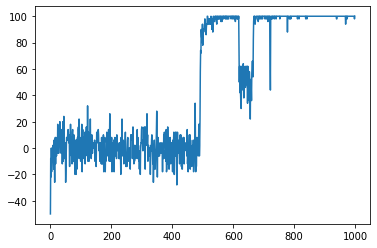

In [8]:
plt.plot(np.array(L).reshape(1000,-1).sum(1))

### 3. The actor-critic loss [reference](https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic)

Since we are using a hybrid actor-critic model, we will use loss function that is a combination of actor and critic losses for training, as shown below:

$$L = L_{actor} + L_{critic}$$

#### Actor loss

We formulate the actor loss based on [policy gradients with the critic as a state dependent baseline](https://www.youtube.com/watch?v=EKqxumCuAAY&t=62m23s) and compute single-sample (per-episode) estimates.

$$L_{actor} = -\sum^{T}_{t=1} log\pi_{\theta}(a_{t} | s_{t})[G(s_{t}, a_{t})  - V^{\pi}_{\theta}(s_{t})]$$

where:
- $T$: the number of timesteps per episode, which can vary per episode
- $s_{t}$: the state at timestep $t$
- $a_{t}$: chosen action at timestep $t$ given state $s$
- $\pi_{\theta}$: is the policy (actor) parameterized by $\theta$
- $V^{\pi}_{\theta}$: is the value function (critic) also parameterized by $\theta$
- $G = G_{t}$: the expected return for a given state, action pair at timestep $t$

We add a negative term to the sum since we want to maximize the probabilities of actions yielding higher rewards by minimizing the combined loss.

<br>

##### Advantage

The $G - V$ term in our $L_{actor}$ formulation is called the [advantage](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions), which indicates how much better an action is given a particular state over a random action selected according to the policy $\pi$ for that state.

While it's possible to exclude a baseline, this may result in high variance during training. And the nice thing about choosing the critic $V$ as a baseline is that it trained to be as close as possible to $G$, leading to a lower variance.

In addition, without the critic, the algorithm would try to increase probabilities for actions taken on a particular state based on expected return, which may not make much of a difference if the relative probabilities between actions remain the same.

For instance, suppose that two actions for a given state would yield the same expected return. Without the critic, the algorithm would try to raise the probability of these actions based on the objective $J$. With the critic, it may turn out that there's no advantage ($G - V = 0$) and thus no benefit gained in increasing the actions' probabilities and the algorithm would set the gradients to zero.

<br>

#### Critic loss

Training $V$ to be as close possible to $G$ can be set up as a regression problem with the following loss function:

$$L_{critic} = L_{\delta}(G, V^{\pi}_{\theta})$$

where $L_{\delta}$ is the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss), which is less sensitive to outliers in data than squared-error loss.
